In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

# Tutorial

In [2]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation

### 3.2 A graph in Torch Geometric
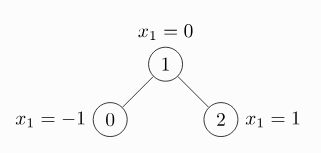

In [3]:
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
edge_index = np.array([[0, 1],
                       [1, 0],
                       [1, 2],
                       [2, 1]])
edge_index = torch.tensor(edge_index.T, dtype=torch.long)

graph = Data(x=x, edge_index=edge_index)
graph

Data(x=[3, 1], edge_index=[2, 4])

In [4]:
# Inspecting the graph
for key, item in graph:
    print(f"graph['{key}'] =",item)

graph['x'] = tensor([[-1.],
        [ 0.],
        [ 1.]])
graph['edge_index'] = tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


### 3.3 Adjacency matrix
Use the `to_dense_adj` function to get the entire adjacency matrix from the edges:

In [5]:
adj_matrix = to_dense_adj(graph.edge_index)
adj_matrix

tensor([[[0., 1., 0.],
         [1., 0., 1.],
         [0., 1., 0.]]])

This can be used to e.g. find the spectrum of the adjacency matrix, here if it is symmetric:

In [6]:
eig = torch.linalg.eigvalsh(adj_matrix)
eig

tensor([[-1.4142e+00,  3.4459e-08,  1.4142e+00]])

### 3.4 More info on a graph
The `Data` class is prepared for storing more information, e.g. a property, `y`, and some meta-information about the positions, `pos`, of the nodes in some space. Example:

In [7]:
y = 42
pos = np.array([[0,0], [1, 0.5], [2, 0]])
graph = Data(x=x, edge_index=edge_index, y=y, pos=pos)
graph

Data(x=[3, 1], edge_index=[2, 4], y=42, pos=[3, 2])

In [8]:
# Retrieve property
graph.y

42

And the positions can be used for plotting. You can write your own function for that, e.g.:

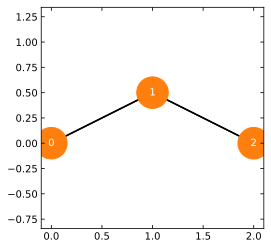

In [9]:
def plot_graph(ax, graph):

    # Plot the nodes:
    for idx, pos in enumerate(graph.pos):
        ax.scatter(*pos.T, c='C1', s=1000)
        ax.text(*pos.T, f'{idx}', color='w', ha='center', va='center')    
    
    # Plot the edges:
    for idx, (i1,i2) in enumerate(graph.edge_index.T):
        ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)

    ax.axis('equal')

fig, ax = plt.subplots(figsize=(4,4))
plot_graph(ax, graph)

### 3.5 Dataloader
Torch Geometric has its own `Dataloader`. Assume that you set up a list of three graphs, `list_of_graphs`, then the `Dataloader` is used like this:

In [10]:
list_of_graphs = [graph, graph, graph]
loader = DataLoader(list_of_graphs, batch_size=2, shuffle=True)

You can now iterate over it:

In [11]:
for batch in loader:
     print(batch)

DataBatch(x=[6, 1], edge_index=[2, 8], y=[2], pos=[2], batch=[6], ptr=[3])
DataBatch(x=[3, 1], edge_index=[2, 4], y=[1], pos=[1], batch=[3], ptr=[2])


You may inspect some attributes on the first `DataBatch`:

In [12]:
for batch in loader:
    print('x:',batch.x)
    print('edges:',batch.edge_index)
    print('batch:',batch.batch)
    print('ptr:',batch.ptr)
    break

x: tensor([[-1.],
        [ 0.],
        [ 1.],
        [-1.],
        [ 0.],
        [ 1.]])
edges: tensor([[0, 1, 1, 2, 3, 4, 4, 5],
        [1, 0, 2, 1, 4, 3, 5, 4]])
batch: tensor([0, 0, 0, 1, 1, 1])
ptr: tensor([0, 3, 6])


### 3.6 Why is `DataBatch` a larger graph?
The trick in Torch Geometric's batching is to represent the adjacency matrix of each graph appearing as a block in a large sparse block diagonal adjacency matrix:

In [13]:
for batch in loader:
    adj_matrix = to_dense_adj(batch.edge_index)
    print(adj_matrix)
    break

tensor([[[0., 1., 0., 0., 0., 0.],
         [1., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.],
         [0., 0., 0., 0., 1., 0.]]])


### 3.7 Message passing
To illustrate message passing, consider the 3-node graph from above, but now with new node values:

In [14]:
x = torch.tensor([[5], [20], [100]], dtype=torch.float)
graph.x = x
graph.x

tensor([[  5.],
        [ 20.],
        [100.]])

A class for passing messages may be written like this:

In [15]:
class CustomMessagePassing(MessagePassing):
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

custom_message_passing = CustomMessagePassing(aggr='add')

Now the messages can be sent:

In [16]:
custom_message_passing(graph.x, graph.edge_index)

tensor([[ 20.],
        [105.],
        [ 20.]])

Changing the aggregation method to multiplication it looks like this:

In [17]:
custom_message_passing = CustomMessagePassing(aggr='mul')
custom_message_passing(graph.x, graph.edge_index)

tensor([[ 20.],
        [500.],
        [ 20.]])

### 3.8 Aggregation
As a final operation required, consider:

In [18]:
aggr = SumAggregation()
print(graph.x, aggr(graph.x, graph.batch), sep='\n')

tensor([[  5.],
        [ 20.],
        [100.]])
tensor([[125.]])


Torch Geometric has a function that does the exact same thing as a `SumAggregation` instance. The function is called `global_add_pool` and is imported and used like this:

In [19]:
from torch_geometric.nn import global_add_pool
graph_level_features = global_add_pool(graph.x, graph.batch)
print(graph_level_features)

tensor([[125.]])


# GNN Models

### 4.1 GNN
The simplest form for a Graph Neural Network (GNN) is one, where a node value is updated via aggregation of the node values on neighboring nodes, $\mathcal{N}$. For the $i$'th node it looks like this:
$$ x_i^{k+1} = \bigoplus_{j\in\mathcal{N}_i} x_j^k, $$
where the superscript $k$ refers to before the update and $k+1$ to after the update.

In [20]:
from torch_geometric.nn import MessagePassing

class MessagePassingNoPsi(MessagePassing):
    def __init__(self,aggr='add'):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j): 
        return x_j

### 4.2 GNN with $\psi$
A slightly more complicated form for a Graph Neural Network (GNN) is one, where a function, $\psi$, is applied to the neighboring node values before they are aggregated:
$$ x_i^{k+1} = \bigoplus_{j\in\mathcal{N}_i} \psi(x_j^k). $$

In [21]:
from torch_geometric.nn import MessagePassing

class MessagePassingWithPsi(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_out)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return self.psi(x_j)

message_passing_with_psi = MessagePassingWithPsi(1, 3, aggr='add')

### 4.3 GNN with $\phi$, $c_{ij}$, and $\psi$.
To implement an operation of the form
$$ x_i^{k+1} = \phi\left(x_i, \bigoplus_{j\in\mathcal{N}_i} c_{ij} \psi(x_j^k)\right), $$
using `torch_geometric.nn.MessagePassing`, you can break down the components as follows:

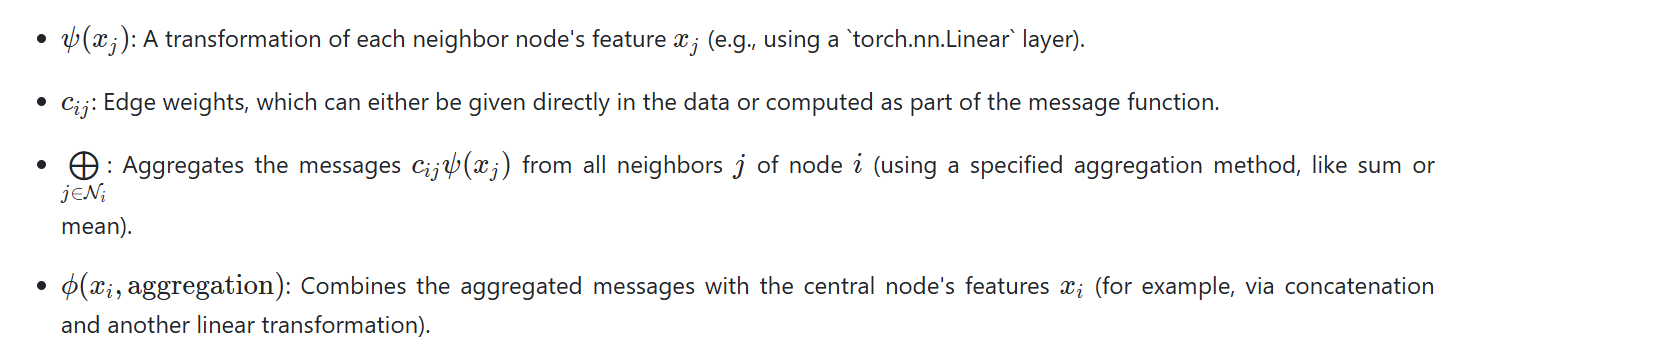

Here's how this can look in a subclass of `MessagePassing`:

In [22]:
from torch_geometric.nn import MessagePassing

class CustomMessagePassing(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_out)
        self.phi = torch.nn.Linear(d_in + d_out, d_out)

    def forward(self, x, edge_index, edge_weight=None):
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight)
        out = self.phi(torch.cat([x, out], dim=1))
        return out

    def message(self, x_j, edge_weight):
        msg = self.psi(x_j)
        if edge_weight is not None:
            msg = msg * edge_weight.view(-1, 1)
        
        return msg